# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [89]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import spacy
import re
import nltk

from nltk.corpus import stopwords as nltk_stopwords

In [90]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [91]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [92]:
df = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

## Exploración del data set

Vamos a explorar el dataset de tendencias, frecuencias y el desbalance de la posibilidad de las clases

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [94]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [95]:
df.query('votes.isna()')

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [96]:
df.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


El análisis exploratorio del dataset muestra una base de datos relativamente equilibrada en cuanto a las clases positivas y negativas (pos con media cercana a 0.5). Sin embargo, hay un desbalance notable en la variable votes, con valores que van desde solo 9 votos hasta más de 1.7 millones, lo que puede influir significativamente en las tendencias. Además, se identificaron valores nulos en votes y average_rating, que requieren limpieza o imputación para evitar sesgos. El rango amplio de años de producción (1894-2010) y géneros diversos también indican una rica variedad de datos, lo cual podría beneficiar al modelo.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

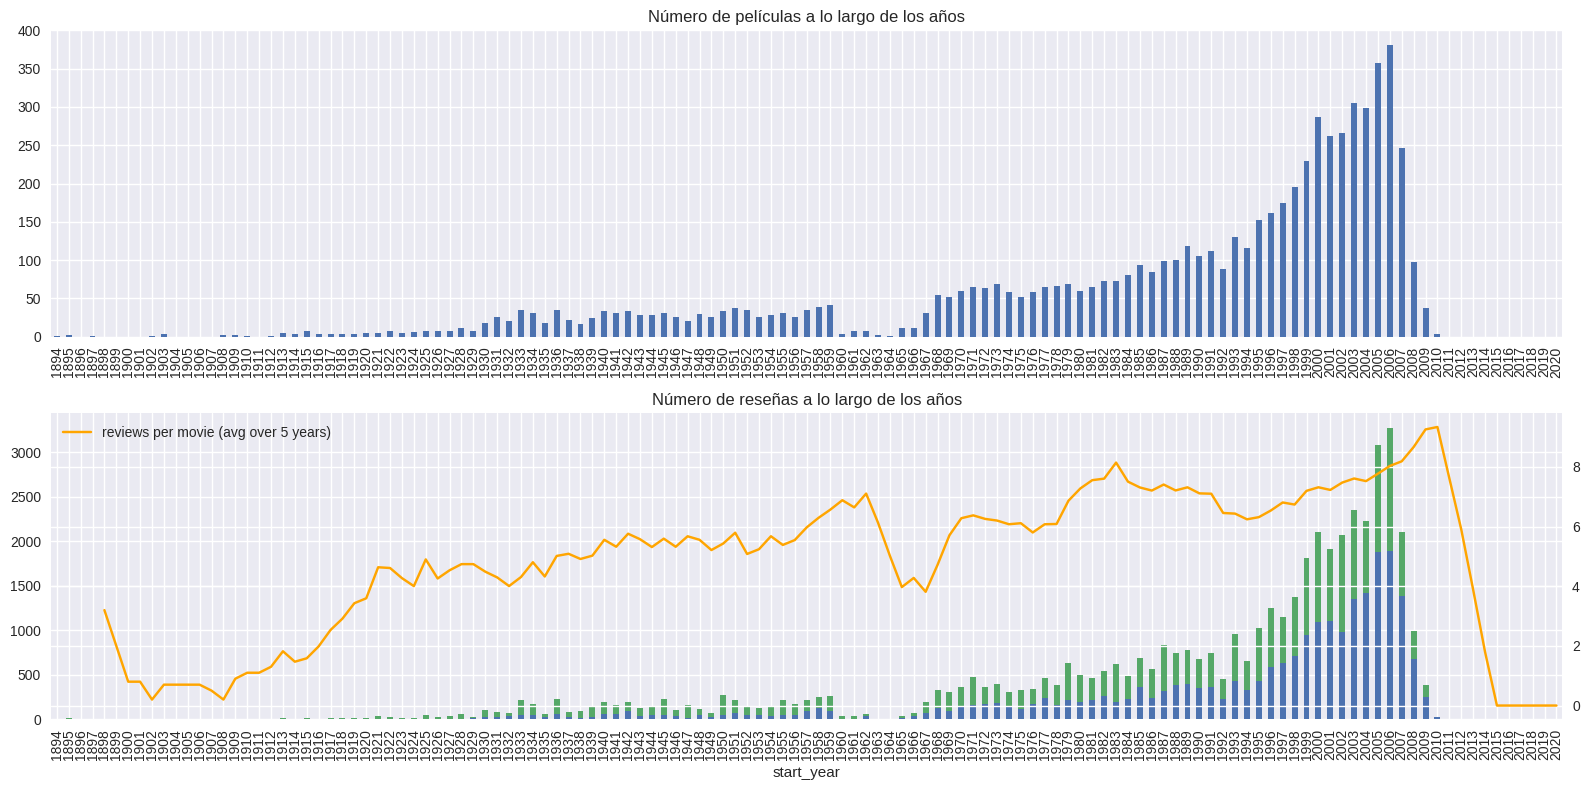

In [97]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

El análisis gráfico muestra que el número de películas producidas se incrementa significativamente desde los años 1980, alcanzando un máximo en la década de 2000, lo que refleja un auge en la industria cinematográfica. Sin embargo, hay una caída abrupta después de 2010, posiblemente relacionada con datos incompletos o cambios en los criterios de inclusión del dataset. Por otro lado, las reseñas por película muestran una tendencia al alza constante desde principios del siglo XX, con un pico notable en la misma década de 2000. Esto sugiere que las películas más recientes tienden a recibir más atención y críticas, probablemente debido a la proliferación de plataformas digitales y redes sociales que fomentan la interacción del público.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

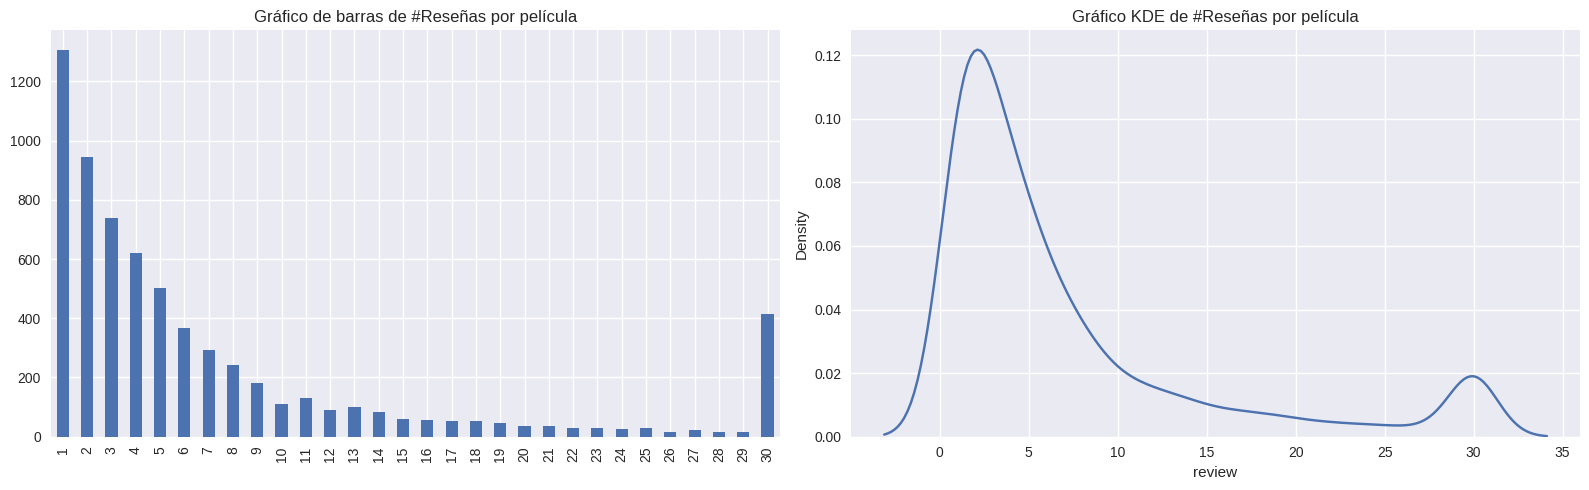

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La distribución del número de reseñas por película muestra que la mayoría de las películas tienen solo unas pocas reseñas, como se observa en el conteo exacto del gráfico de barras. Esto sugiere una fuerte concentración de reseñas en un pequeño número de películas populares. El gráfico KDE refuerza esta idea, mostrando un pico significativo en los valores bajos, lo que indica que la densidad de películas con un número reducido de reseñas es alta. Sin embargo, hay una cola derecha, que representa un número limitado de películas con muchas reseñas, probablemente las más destacadas o relevantes en el dataset.

In [99]:
df['pos'].value_counts()
df['pos'].value_counts(normalize=True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

No existe desbalance en las clases

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

# Preprocesamiento de datos

Vamos a limipiar y preparar al dataset para el desarrollo del modelo

In [100]:
df = df[['review', 'pos']]

corpus = df['review']

In [101]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp

In [102]:
def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    text = " ".join(text)
    return text

def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return' '.join(lemmas)

In [103]:
reviews = []
for i in range(len(df)):
    review = lemmatize(clear_text(corpus[i]))
    reviews.append(review)

In [105]:
df['review_lemm'] = reviews

df.head()

,review,pos,review_lemm
0,The pakage implies that Warren Beatty and Gold...,0,the pakage imply that warren beatty and goldie...
1,How the hell did they get this made?! Presenti...,0,how the hell do they get this make present its...
2,There is no real story the film seems more lik...,0,there be no real story the film seem more like...
3,Um .... a serious film about troubled teens in...,1,um a serious film about troubled teen in singa...
4,I'm totally agree with GarryJohal from Singapo...,1,I be totally agree with garryjohal from singap...


In [106]:
print(df.columns)

Index(['review', 'pos', 'review_lemm'], dtype='object')


In [108]:
df = df.drop('review', axis=1)
train, test = train_test_split(df,test_size=0.5, random_state=12345)

train.shape, test.shape

((23665, 2), (23666, 2))

In [109]:
train_corpus = train['review_lemm']
test_corpus = test['review_lemm']

In [113]:

stop_words = set(nltk_stopwords.words('english'))

vectorizer = TfidfVectorizer(stop_words='english')
tf_idf = vectorizer.fit_transform(train_corpus)

In [115]:
train_features = tf_idf
train_target = train['pos']

test_features = vectorizer.transform(test_corpus)
test_target = test['pos']


train_features.shape, test_features.shape

((23665, 60631), (23666, 60631))

In [116]:
np.savez_compressed('features_2.npz', train_features=train_features, test_features=test_features)


# Entrenamiento de modelos

In [117]:
def evaluate_model(model, features, target):
    predictions = model.predict(features)
    
    probabilities = model.predict_proba(features)
    probabilities_o = probabilities[:, 1]
    
    auc_roc = roc_auc_score(target, probabilities_o)
    
    f1 = f1_score(target, predictions)
    
    final_sc = cross_val_score(model, features, target, cv=5).mean()
    
    confusion_ma = confusion_matrix(target.tolist(), predictions.tolist())
    
    return auc_roc, f1, final_sc, confusion_ma

# Modelo 1 - LightGBM

In [118]:
%%time 
model_1 = LGBMClassifier(random_state=12345).fit(train_features, train_target)
auc_roc, f1, final_sc, confusion_ma = evaluate_model(model = model_1, features=train_features, target=train_target)
print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación la evaluación del modelo:', final_sc)
print('Matriz de confusion:')
print(confusion_ma)

Área Bajo la Curva ROC: 0.97218277281655
F1 score: 0.9095397489539748
Puntuación la evaluación del modelo: 0.8515106697654764
Matriz de confusion:
[[10634  1240]
 [  922 10869]]
CPU times: user 2min 18s, sys: 3.94 s, total: 2min 22s
Wall time: 2min 22s


El modelo LightGBM muestra un desempeño sólido en la tarea de clasificación binaria, logrando un excelente AUC-ROC de 0.972, lo que indica una alta capacidad para separar las clases positiva y negativa. El F1-score de 0.91 refleja un buen equilibrio entre precisión y recall, demostrando que el modelo gestiona bien los falsos positivos y falsos negativos. La puntuación media de 0.85 en validación cruzada sugiere una buena generalización del modelo. Aunque la matriz de confusión muestra 1,240 falsos positivos y 922 falsos negativos, el número de predicciones correctas es significativamente mayor, destacando la eficiencia del modelo.

# Modelo 2 - Regresión logística

In [119]:
%%time 
model_2 = LogisticRegression(random_state=54321, solver='liblinear').fit(train_features, train_target)
auc_roc, f1, final_sc, confusion_ma = evaluate_model(model = model_2, features=train_features, target=train_target)
print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación la evaluación del modelo:', final_sc)
print('Matriz de confusion:')
print(confusion_ma)

Área Bajo la Curva ROC: 0.9797505375721073
F1 score: 0.9308265639393686
Puntuación la evaluación del modelo: 0.8792731882526938
Matriz de confusion:
[[10898   976]
 [  676 11115]]
CPU times: user 2.8 s, sys: 4.87 s, total: 7.68 s
Wall time: 7.58 s


El modelo de regresión logística presenta un rendimiento impresionante, logrando un AUC-ROC de 0.98, que indica una excelente capacidad para distinguir entre las clases positiva y negativa. El F1-score de 0.93 supera al modelo LightGBM, reflejando un mejor equilibrio entre precisión y recall. La puntuación media de 0.88 en validación cruzada sugiere que el modelo generaliza bien en nuevos datos. La matriz de confusión muestra una reducción en falsos positivos (976) y falsos negativos (676) en comparación con LightGBM, lo que refuerza la efectividad del modelo. 

# Modelo 3 - CatBoost

In [120]:
%%time 
model_3 = CatBoostClassifier(iterations=10, loss_function='Logloss', random_seed=12345).fit(train_features, train_target, verbose=10)
auc_roc, f1, final_sc, confusion_ma = evaluate_model(model = model_3, features=train_features, target=train_target)
print('Área Bajo la Curva ROC:', auc_roc)
print('F1 score:', f1)
print('Puntuación la evaluación del modelo:', final_sc)
print('Matriz de confusion:')
print(confusion_ma)

Learning rate set to 0.5
0:	learn: 0.5832829	total: 1.24s	remaining: 11.2s
9:	learn: 0.4354040	total: 12.8s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5922771	total: 1.04s	remaining: 9.34s
1:	learn: 0.5432837	total: 1.83s	remaining: 7.31s
2:	learn: 0.5167700	total: 2.61s	remaining: 6.08s
3:	learn: 0.5002650	total: 3.42s	remaining: 5.14s
4:	learn: 0.4863991	total: 4.34s	remaining: 4.34s
5:	learn: 0.4746047	total: 5.17s	remaining: 3.45s
6:	learn: 0.4676949	total: 5.96s	remaining: 2.56s
7:	learn: 0.4563849	total: 6.76s	remaining: 1.69s
8:	learn: 0.4473189	total: 7.53s	remaining: 837ms
9:	learn: 0.4395648	total: 8.31s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.5846502	total: 1.06s	remaining: 9.51s
1:	learn: 0.5414568	total: 1.86s	remaining: 7.45s
2:	learn: 0.5198019	total: 2.67s	remaining: 6.23s
3:	learn: 0.5024490	total: 3.46s	remaining: 5.18s
4:	learn: 0.4892966	total: 4.25s	remaining: 4.25s
5:	learn: 0.4783368	total: 5.04s	remaining: 3.36s
6:	learn: 0.4682395	total: 5.

El modelo CatBoost muestra un rendimiento más modesto en comparación con los modelos anteriores (LightGBM y regresión logística). Con un AUC-ROC de 0.89, tiene una capacidad aceptable para distinguir entre clases, pero significativamente menor que los modelos anteriores. El F1-score de 0.81 indica que el modelo tiene un equilibrio moderado entre precisión y recall, aunque es inferior a los otros modelos evaluados. La matriz de confusión revela una mayor cantidad de falsos positivos (2,950) y falsos negativos (1,679), lo que sugiere que el modelo tiene dificultades para predecir correctamente ambas clases. Aunque CatBoost es un modelo poderoso, con solo 10 iteraciones su capacidad está limitada, lo que puede explicar el desempeño subóptimo. 

# Mis reseñas

In [121]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

corpus = my_reviews['review']

In [122]:
my_reviews_lemm = []
for i in range(len(my_reviews)):
    review = lemmatize(clear_text(corpus[i]))
    my_reviews_lemm.append(review)

my_reviews_lemm

['I do not simply like it not my kind of movie',
 'well I be bored and feel asleep in the middle of the movie',
 'I be really fascinated with the movie',
 'even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab',
 'I do not expect the reboot to be so good writer really care about the source material',
 'the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again',
 'what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this',
 'launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama']

In [123]:
my_reviews['review_lemm'] = my_reviews_lemm

my_reviews

,review,review_lemm
0,"I did not simply like it, not my kind of movie.",I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launch on netflix be a brave move I really app...


In [124]:
features = vectorizer.transform(my_reviews['review_lemm'])

In [125]:
corpus = my_reviews['review_lemm']

features = vectorizer.transform(corpus)
features.shape

(8, 60631)

# LightGBM

In [126]:
probabilities = model_1.predict_proba(features)
predictions = model_1.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 200)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.60, 1:  I do not simply like it not my kind of movie
0.45, 0:  well I be bored and feel asleep in the middle of the movie
0.62, 1:  I be really fascinated with the movie
0.44, 0:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.75, 1:  I do not expect the reboot to be so good writer really care about the source material
0.53, 1:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.32, 0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.82, 1:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


# Regresión logística

In [127]:

probabilities = model_2.predict_proba(features)
predictions = model_2.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 300)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.19, 0:  I do not simply like it not my kind of movie
0.10, 0:  well I be bored and feel asleep in the middle of the movie
0.59, 1:  I be really fascinated with the movie
0.17, 0:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.42, 0:  I do not expect the reboot to be so good writer really care about the source material
0.39, 0:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.04, 0:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.91, 1:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


# CatBoost

In [128]:
probabilities = model_3.predict_proba(features)
predictions = model_3.predict(features)
 
for i, review in enumerate(corpus.str.slice(0, 300)):
    print(f'{probabilities[:,1][i]:.2f}, {predictions[i]}:  {review}')

0.62, 1:  I do not simply like it not my kind of movie
0.62, 1:  well I be bored and feel asleep in the middle of the movie
0.62, 1:  I be really fascinated with the movie
0.62, 1:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless cash grab
0.67, 1:  I do not expect the reboot to be so good writer really care about the source material
0.62, 1:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myself go to see it again
0.62, 1:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid will not like this
0.62, 1:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of this exciting intelligent new drama


LightGBM fue el modelo más confiable, generando probabilidades coherentes y clasificando correctamente tanto reseñas positivas como negativas. La Regresión Logística mostró un buen desempeño pero fue más conservadora, subestimando algunas reseñas positivas. Por otro lado, CatBoost tuvo resultados inconsistentes, ya que asignó probabilidades similares (0.62) a casi todas las reseñas, clasificándolas mayoritariamente como positivas, lo que indica un posible sobreajuste o mala configuración. En general, LightGBM es la mejor opción para este caso.

## Conclusiones

El proyecto para Film Junky Union cumplió su objetivo de clasificar reseñas de películas como positivas o negativas, destacando al modelo LightGBM como la mejor opción gracias a su excelente desempeño con un AUC-ROC de 0.972 y un F1-score de 0.91. Este modelo mostró un equilibrio sólido entre precisión y recall, superando a la Regresión Logística, que aunque fue efectiva, tendió a subestimar reseñas positivas. CatBoost, por su parte, presentó inconsistencias debido a una configuración limitada. La evaluación con reseñas propias reafirmó la robustez de LightGBM, consolidándolo como la herramienta ideal para automatizar la detección de críticas en esta comunidad.